In [1]:
import pandas as pd
import numpy as np
import re
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics, preprocessing

from tensorflow.keras import models, layers, utils

2022-06-06 11:24:14.826013: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-06 11:24:14.826046: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# !pip install tensorflow

# Data preprocessing

The files *movies* and *ratings* contain respectively the products data and the users data.

In [3]:
df_products = pd.read_csv("~/work/recommendation_system/dataset/movies.csv") 

In [4]:
df_products.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In the *movies* dataset every row represents an item and the two last columns contains the feature which can be seen as movie metadata.. The data dictionary of *movies* is :
+ **movieid** : identifier of movie
+ **title** : title of movie
+ **genres** : set of categories from which movie is apart

In [5]:
df_users = pd.read_csv("~/work/recommendation_system/dataset/ratings.csv") 

In [6]:
df_users.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


For users dataset, every row is pair of user-product and shows the rating the user has given to products, which is the **target variable**. The data dictionary of *ratings* is :
+ **movieid** : identifier of user
+ **movieid** : identifier of movie that the user watches
+ **rating** : rating user has given to the movie
+ **timestamp** : time spent on movie

Let do a data cleaning and feature engineering to better understand the data

In [7]:
## product dataset
df_products = df_products[~df_products["genres"].isna()]

df_products["product"] = range(0, len(df_products))

df_products["name"] = df_products["title"].apply(lambda x :re.sub("[\(\[].*?[\)\]]", "", x).strip())

df_products["date"] = df_products["title"].apply(lambda x: int(x.split("(")[-1].replace(")","").strip()) if "(" in x and "–" not in x else np.nan)

df_products["list_genres"] = df_products["genres"].apply(lambda x : re.compile("(\w+)").findall(x))

df_products["date"] = df_products["date"].fillna(9999)

df_products["old"] = df_products["date"].apply(lambda x: 1 if x < 2000 else 0)

In [8]:
df_products

,movieId,title,genres,product,name,date,list_genres,old
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,Toy Story,1995.0,"[Adventure, Animation, Children, Comedy, Fantasy]",1
1,2,Jumanji (1995),Adventure|Children|Fantasy,1,Jumanji,1995.0,"[Adventure, Children, Fantasy]",1
2,3,Grumpier Old Men (1995),Comedy|Romance,2,Grumpier Old Men,1995.0,"[Comedy, Romance]",1
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,3,Waiting to Exhale,1995.0,"[Comedy, Drama, Romance]",1
4,5,Father of the Bride Part II (1995),Comedy,4,Father of the Bride Part II,1995.0,[Comedy],1
...,...,...,...,...,...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy,9737,Black Butler: Book of the Atlantic,2017.0,"[Action, Animation, Comedy, Fantasy]",0
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,9738,No Game No Life: Zero,2017.0,"[Animation, Comedy, Fantasy]",0
9739,193585,Flint (2017),Drama,9739,Flint,2017.0,[Drama],0
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation,9740,Bungo Stray Dogs: Dead Apple,2018.0,"[Action, Animation]",0


For the users dataset, we extract two variables from the timestamp column : *daytime* and *weekend*

In [9]:
## user dataset

df_users["user"] = df_users["userId"].apply(lambda x: x-1)

df_users["timestamp"] = df_users["timestamp"].apply(lambda x: datetime.fromtimestamp(x))

# shows if user looks the movie in a daytime
df_users["daytime"] = df_users["timestamp"].apply(lambda x: 1 if 6<int(x.strftime("%H"))<20 else 0)

df_users["weekend"] = df_users["timestamp"].apply(lambda x: 1 if x.weekday() in [5, 6] else 0)

df_users = df_users.merge(df_products[["movieId", "product"]], how="left")

df_users = df_users.rename(columns={"rating":"y"})

In [10]:
# Clean dataset
df_products = df_products[["product", "name", "old", "genres"]].set_index("product")

df_users = df_users[["user", "product", "daytime", "weekend", "y"]]

In [11]:
df_users.head()

,user,product,daytime,weekend,y
0,0,0,1,1,4.0
1,0,2,1,1,4.0
2,0,5,1,1,4.0
3,0,43,1,1,5.0
4,0,46,1,1,5.0


In [12]:
df_products.head()

,name,old,genres
product,,,
0,Toy Story,1,Adventure|Animation|Children|Comedy|Fantasy
1,Jumanji,1,Adventure|Children|Fantasy
2,Grumpier Old Men,1,Comedy|Romance
3,Waiting to Exhale,1,Comedy|Drama|Romance
4,Father of the Bride Part II,1,Comedy


We create the *Products-Features* matrix

In [13]:
tags = [i.split("|") for i in df_products["genres"].unique()]
columns = list(set(i for lst in tags for i in lst))
columns.remove('(no genres listed)')

In [14]:
for col in columns:
    df_products[col] = df_products["genres"].apply(lambda x : 1 if col in x else 0)

In [15]:
df_products.head()

,name,old,genres,Western,Children,Sci-Fi,War,Action,Adventure,Romance,...,Musical,Comedy,Documentary,Crime,Mystery,Horror,Thriller,Drama,Animation,Film-Noir
product,,,,,,,,,,,,,,,,,,,,,
0,Toy Story,1,Adventure|Animation|Children|Comedy|Fantasy,0,1,0,0,0,1,0,...,0,1,0,0,0,0,0,0,1,0
1,Jumanji,1,Adventure|Children|Fantasy,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,Grumpier Old Men,1,Comedy|Romance,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
3,Waiting to Exhale,1,Comedy|Drama|Romance,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,1,0,0
4,Father of the Bride Part II,1,Comedy,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


The matrix is sparse as most of the products don’t have all the features. Let’s visualize it to understand better the situation.

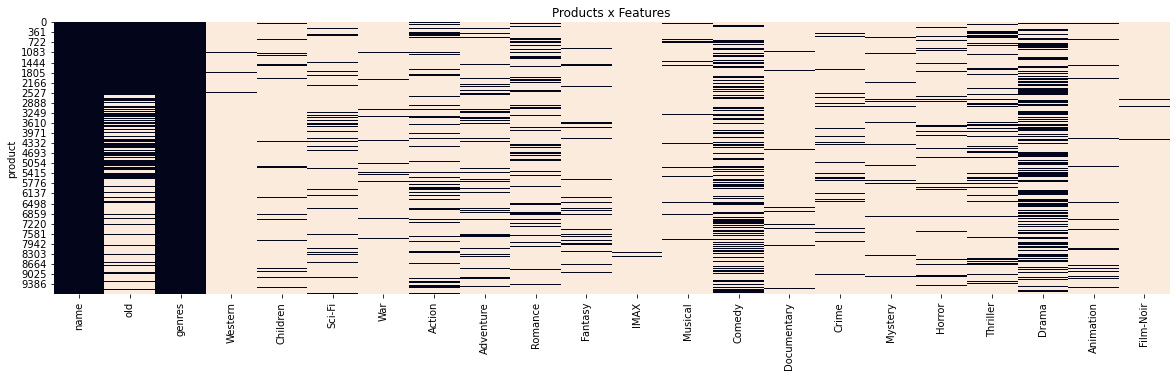

In [16]:
fig, ax = plt.subplots(figsize=(20,5))
sns.heatmap(df_products==0, vmin=0, vmax=1, cbar=False, ax=ax).set_title("Products x Features")
plt.show()

In [17]:
tmp = df_users.copy()
df_users = tmp.pivot_table(index="user", columns="product", values="y")
missing_cols = list(set(df_products.index) - set(df_users.columns))
for col in missing_cols:
    df_users[col] = np.nan
dF_users = df_users[sorted(df_users.columns)]

In [18]:
dF_users

product,0,1,2,3,4,5,6,7,8,9,...,9732,9733,9734,9735,9736,9737,9738,9739,9740,9741
user,,,,,,,,,,,,,,,,,,,,,
0,4.0,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605,2.5,NaN,NaN,NaN,NaN,NaN,2.5,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
606,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
607,2.5,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


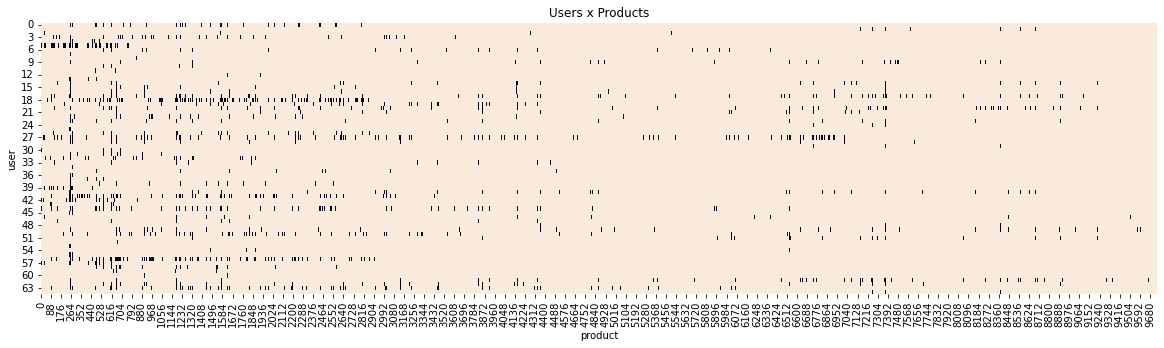

In [19]:
fig, ax = plt.subplots(figsize=(20,5))
sns.heatmap(np.isnan(dF_users.head(65)), cbar=False, ax=ax).set_title("Users x Products")
plt.show()

We will deal with Neural Networs, a good practice is to scale the data. In this cases we scale the data between 0.5 and 1

In [20]:
# scaling
df_users = pd.DataFrame(preprocessing.MinMaxScaler(feature_range=(0.5, 1)).fit_transform(df_users.values), 
                        columns=df_users.columns, 
                        index=df_users.index)

/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:461: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:462: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


In [21]:
df_users

product,0,1,2,3,4,5,6,7,8,9,...,3118,5421,816,5837,7565,5749,4598,4506,2587,5020
user,,,,,,,,,,,,,,,,,,,,,
0,0.888889,NaN,0.888889,NaN,NaN,0.875,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.888889,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605,0.722222,NaN,NaN,NaN,NaN,NaN,0.6875,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
606,0.888889,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
607,0.722222,0.666667,0.666667,NaN,NaN,NaN,NaN,NaN,NaN,0.888889,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We proceed to split the data into train and test dataset as 80% of data for training and the remaining for testing

In [22]:
split = int(0.8*df_users.shape[1])
df_train = df_users.loc[:, :split-1]
df_test = df_users.loc[:, split:]

# Modeling